# AirMSPI Dynamic Radiance data loading

This notebook demonstrates how to load data from AirMSPI's files. 

A pre-processing is applied on the data for the cloud reconstruction optimization.

---


The source Fortran code was created by Frank Evans and it is part of the SHDOM package: http://nit.colorado.edu/shdom.html

The python wrapper was created by Aviad Levis, Technion Inst. of Technology 2019: https://github.com/aviadlevis/pyshdom

In [17]:
"""
Imports necessary for this notebook
"""
import matplotlib.pyplot as plt
import numpy as np
import shdom
import glob

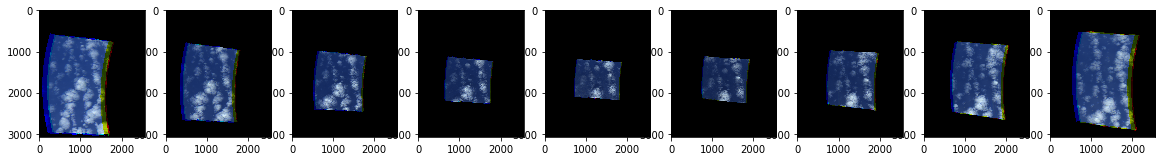

In [18]:
# Set data directory
data_dir = '../AirMSPI/AirMSPI_ER2_GRP_ELLIPSOID_20130206_Pacific-32N123W'
format_ = '*.hdf'  # load
paths = sorted(glob.glob(data_dir + '/' + format_))
n_files = len(paths)
# Show AirMSPI images in data directory
shdom.AirMSPIDynamicMeasurements().imshow(data_dir)

In [19]:
# Crop cloud from images, uses OpenCV package may be problematic in some versions
roi = []
%matplotlib notebook 
# for i in range(n_files):
    # roi.append(shdom.AirMSPIMeasurements().select_region_of_interest(data_dir,i))



In [20]:
# pre-calculate region of interest for demonstration for 
# AirMSPI_ER2_GRP_ELLIPSOID_20130206_Pacific-32N123W data
roi = [[1552, 2072, 780, 1288], [1644, 2108, 864, 1308], [1696, 2176, 916, 1376], [1740, 2196, 936, 1400], [1840, 2108, 1040, 1432], [1884, 2160, 1064, 1500], [1944, 2316, 1116, 1540], [1972, 2480, 1136, 1600], [2052, 2544, 1204, 1640]]

valid_wavelength = [660]
airmspi_measurements = shdom.AirMSPIDynamicMeasurements()
airmspi_measurements.load_from_hdf(data_dir,region_of_interest=roi,valid_wavelength=valid_wavelength)

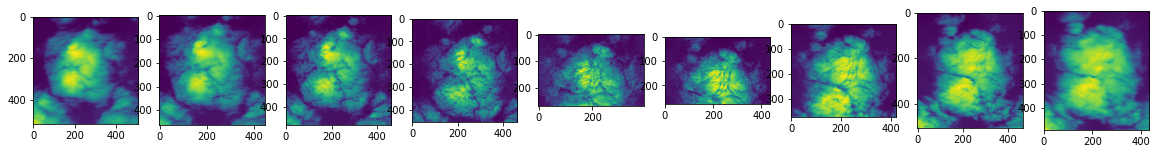

In [21]:
# View images

%matplotlib inline
f, axarr = plt.subplots(1, len(airmspi_measurements.images), figsize=(20, 20))
if isinstance(axarr,plt.Axes):
    axarr = [axarr]
for ax, image in zip(axarr, airmspi_measurements.images):
    if len(image.shape)>2 and image.shape[2]==2:
        image = np.concatenate((np.reshape(image[:,:,0],(image.shape[0],image.shape[1],1)),image),2)
    elif len(image.shape)>2 and image.shape[2]>3:
        image = image[:,:,0:2]
    image -= image.min()
    ax.imshow(image/image.max())
    

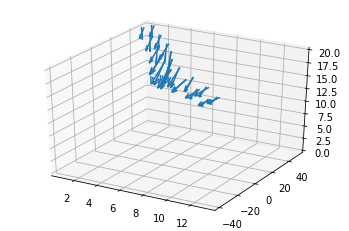

In [22]:
# Plot locations of the cameras

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init()
x_min = airmspi_measurements.camera.projection.x.min()
x_max = airmspi_measurements.camera.projection.x.max()
y_min = airmspi_measurements.camera.projection.y.min()
y_max = airmspi_measurements.camera.projection.y.max()
airmspi_measurements.plot(ax,[x_min, x_max],[y_min, y_max],[0, 20],5)

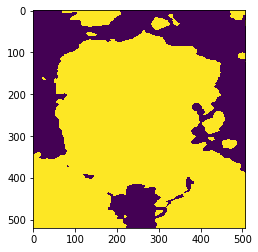

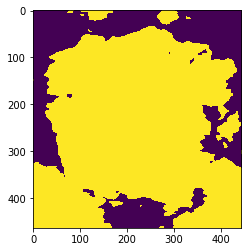

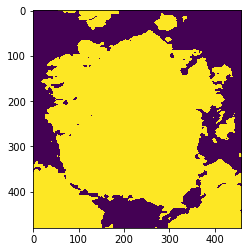

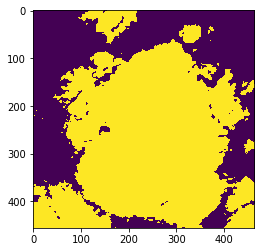

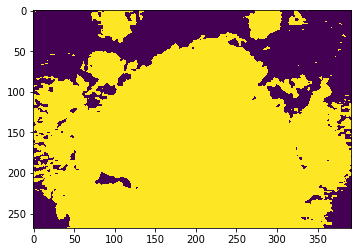

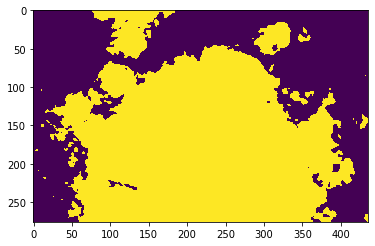

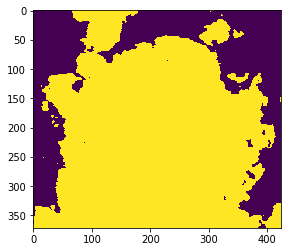

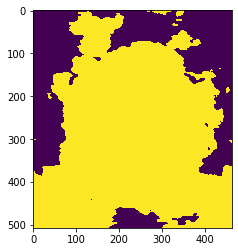

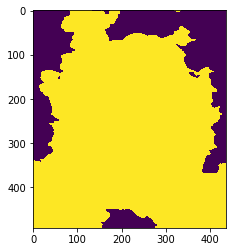

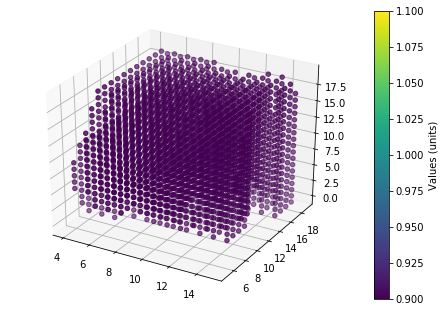

2753


In [23]:
# Test cloud's pre-processing alignment by space carve object  
nx = 20
ny = 20
nz = 20
grid = shdom.Grid(bounding_box=airmspi_measurements.bb,nx=nx,ny=ny,nz=nz)

carver = shdom.DynamicSpaceCarver(airmspi_measurements)
mask_list, best_dynamic_grid, cloud_velocity = carver.carve(grid, agreement=0.9, thresholds=0.01,time_list=airmspi_measurements._time_list, vx_max=10,vy_max=10)
shdom.cloud_plot(mask_list[0].data)
print(sum(sum(sum(mask_list[0].data))))

In [24]:
# Save AirMSPI measurments
if len(valid_wavelength) == 1:
    output_dir = 'experiments/AirMSPI/dynamic_medium/monochromatic'
else:
    output_dir = 'experiments/AirMSPI/dynamic_medium/polychromatic'
airmspi_measurements.save_airmspi_measurements(output_dir)